# Predict Student Performance from Game Play

## Project Introduction

Learning can be fun. There are many educational platforms exploring the space of gamified learning. 

The gamified learning experience offers a powerful approach to education, leveraging the motivational aspects of games to enhance engagement, retention, and collaboration. By incorporating game elements into the learning process, educators can create immersive and interactive educational environments that foster a love for learning and empower learners to reach their full potential.

Good examples of successful gamified learning spaces are [PBS Wisconsin Education](https://pbswisconsineducation.org/) and [Education.com](https://www.education.com/games/).

This project uses data from the [Kaggle Competition: Predict Student Performance from Game Play](https://www.kaggle.com/competitions/predict-student-performance-from-game-play/overview). 

## Problem Statement

Develop a reliable model trained on game logs for a group of students, and predict their correctness in answering questions (to assess their learning outcomes).

The model will be helpful in improving the game design to optimise learning outcomes, as well as recommending suitable game content for students’ further learning and practice.

## Data Science Approach

The project deploys a Data Science Approach with the following steps:

- Data Collection 
- Data Cleaning and Preparation
- EDA
- Preprocessing
- Modeling
- Evaluation

## 1. Load data

In [1]:
# import required liabraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics

In [2]:
# reference: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/384359
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

In [3]:
# load the game data:
df_game = pd.read_csv('./data/train.csv', dtype=dtypes)

In [4]:
# show the top 5 rows:
df_game.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [5]:
df_game.shape

(26296946, 20)

In [6]:
# slice the dataframe to study only level 0-4:
df_game = df_game.loc[df_game['level_group']=='0-4']

In [7]:
# print the shape of the dataset:
print(f'Full game dataset shape is {df_game.shape}.')

Full game dataset shape is (3981005, 20).


In [8]:
# load the labels:
df_labels = pd.read_csv('./data/train_labels.csv')

In [9]:
# Each value in the column, session_id is a combination of both the session and the question number. We will split these into individual columns for ease of use.
df_labels['session'] = df_labels.session_id.apply(lambda x: int(x.split('_')[0]) )
df_labels['q'] = df_labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

In [10]:
# show the top 5 rows:
df_labels.head()

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [11]:
df_labels = df_labels.drop(columns=['session_id'])

In [12]:
# slice the label data to study only qn 1-3:
df_labels = df_labels.loc[df_labels['q'] <= 3]

In [13]:
# print the shape of the labels:
print(f'Full label dataset shape is {df_labels.shape}.')

Full label dataset shape is (70686, 3).


Text(0.5, 1.0, 'Correctness of Student Answers for Qn 1-3')

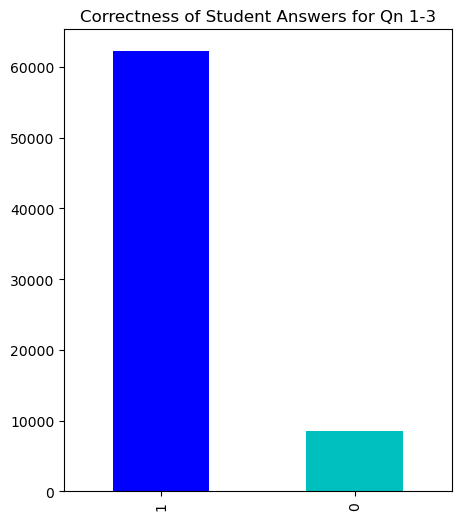

In [14]:
# find out how many answers are correct:
plt.figure(figsize=(5, 6))
plot_df = df_labels.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])
plt.title('Correctness of Student Answers for Qn 1-3')

- Noted the students have a good chance of getting correct answers for Qn 1-3.

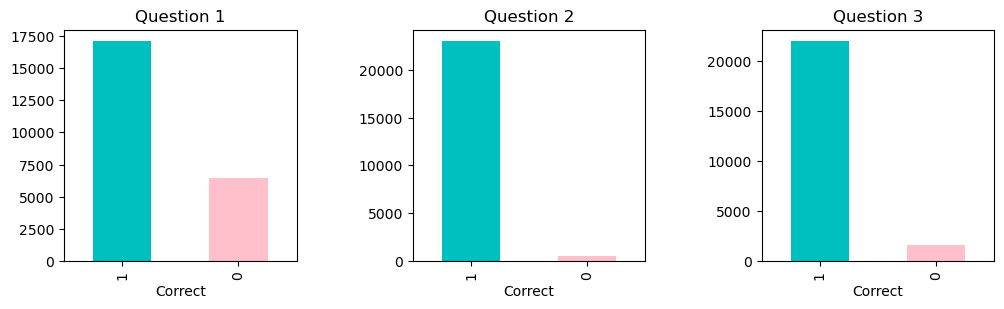

In [15]:
# how about for each answer?

plt.figure(figsize=(12, 3))
plt.subplots_adjust(hspace=1, wspace=0.5)

for n in range(1,4):
    ax = plt.subplot(1, 3, n)

    # filter df and plot ticker on the new subplot axis
    plot_df = df_labels.loc[df_labels.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(ax=ax, kind="bar", color=['c', 'pink'])
    
    # chart formatting
    ax.set_title("Question " + str(n))
    ax.set_xlabel("Correct")

## 2. Prepare the dataset

As summarized in the competition overview, the dataset presents the questions and data to us in order of levels - 0-4. To do this we will create basic aggregate features from the relevant columns. You can create more features to boost your scores.

First, we will create two separate lists with names of the Categorical columns and Numerical columns. We will avoid columns fullscreen, hq and music since they don't add any useful value for this problem statement.

In [16]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

In [17]:
# Reference: https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook
def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [18]:
dataset_df = feature_engineer(df_game)

In [19]:
# prepare the label data:
df_q1 = df_labels.loc[df_labels['q']==1]
df_q2 = df_labels.loc[df_labels['q']==2]
df_q3 = df_labels.loc[df_labels['q']==3]

In [20]:
df_q1 = df_q1.rename(columns = {'correct':'correct_q1'})
df_q1 = df_q1.drop(columns=['q'])

In [21]:
df_q2 = df_q2.rename(columns = {'correct':'correct_q2'})
df_q2 = df_q2.drop(columns=['q'])

In [22]:
df_q3 = df_q3.rename(columns = {'correct':'correct_q3'})
df_q3 = df_q3.drop(columns=['q'])

In [23]:
# combine game data and label data:
df_combine = dataset_df.merge(df_q1, how = 'left', left_on = 'session_id', right_on = 'session')
df_combine = df_combine.merge(df_q2, how = 'left', on = 'session')
df_combine = df_combine.merge(df_q3, how = 'left', on = 'session')

In [24]:
df_combine.head()

,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,room_coor_y,...,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,correct_q1,session,correct_q2,correct_q3
0,10,3,30,7,17,85793.557576,1.945455,-1.0,7.701275,-71.413750,...,-1.0,399.296038,129.292411,214.871000,104.082743,3227.370757,1,20090312431273200,1,1
1,11,4,22,6,11,97633.417266,1.870504,0.0,-84.045959,-53.671082,...,0.0,445.980041,156.186242,252.554707,121.062929,2114.876406,0,20090312433251036,1,1
2,9,3,22,6,12,202398.020134,1.604027,-1.0,-209.830322,-31.125036,...,-1.0,478.652392,161.438387,459.750352,177.665582,4575.148668,1,20090312455206810,1,1
3,11,4,24,6,14,62087.397727,1.789773,0.0,-111.962723,-76.698112,...,0.0,422.766428,161.696460,290.932896,150.691736,1949.073577,0,20090313091715820,1,1
4,10,4,22,6,12,85853.464286,1.767857,0.0,-5.028427,-1.624746,...,0.0,452.898668,176.604685,246.447643,135.253613,1743.134314,1,20090313571836404,1,1


## 3. EDA of the prepared dataset

In [25]:
# a stats summary of the dataset:
df_combine.describe()

,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,room_coor_y,...,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,correct_q1,session,correct_q2,correct_q3
count,23562.000000,23562.000000,23562.000000,23562.000000,23562.000000,2.356200e+04,23562.000000,23562.000000,23562.000000,23562.000000,...,23562.000000,23562.000000,23562.000000,23562.000000,23562.000000,2.356200e+04,23562.000000,2.356200e+04,23562.000000,23562.000000
mean,10.005178,3.653255,23.836262,6.408666,13.554749,5.709876e+05,1.957887,-0.290553,14.841218,-51.104527,...,-0.294031,433.173910,157.750576,249.344920,124.415927,1.275027e+04,0.727485,2.113666e+16,0.978822,0.934004
std,0.965633,0.624986,2.433726,0.491684,2.163845,1.217521e+07,0.156252,0.627683,54.062378,36.260509,...,0.615026,29.350428,20.786631,29.145481,18.520543,6.147821e+05,0.445263,5.704122e+14,0.143981,0.248281
min,7.000000,3.000000,18.000000,5.000000,8.000000,4.627651e+02,0.923372,-1.000000,-249.587692,-211.466599,...,-1.000000,323.419432,90.098533,109.415466,68.257406,-1.000000e+00,0.000000,2.009031e+16,0.000000,0.000000
25%,9.000000,3.000000,22.000000,6.000000,12.000000,8.661494e+04,1.857143,-1.000000,-19.435616,-75.549736,...,-1.000000,413.166156,143.118426,230.666970,111.867450,1.572636e+03,0.000000,2.101031e+16,1.000000,1.000000
50%,10.000000,4.000000,23.000000,6.000000,13.000000,1.196638e+05,1.950262,0.000000,13.902909,-50.912560,...,0.000000,430.896144,156.734269,245.219582,123.106645,2.562640e+03,1.000000,2.104022e+16,1.000000,1.000000
75%,11.000000,4.000000,25.000000,7.000000,15.000000,1.644775e+05,2.051613,0.166667,47.950128,-26.612121,...,0.000000,450.112466,171.336231,263.139308,135.239757,4.224074e+03,1.000000,2.110061e+16,1.000000,1.000000
max,11.000000,6.000000,34.000000,7.000000,25.000000,9.627373e+08,3.269286,1.000000,328.096100,160.347992,...,0.577350,629.880524,248.169337,612.476019,315.846521,7.837739e+07,1.000000,2.210022e+16,1.000000,1.000000


<AxesSubplot:xlabel='level', ylabel='elapsed_time'>

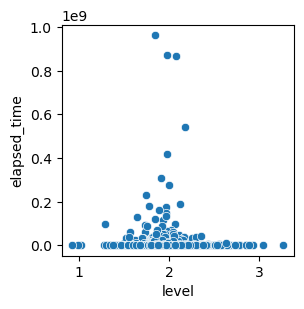

In [26]:
# plot a graph of elapsed time against level:
plt.figure(figsize=(3, 3))
sns.scatterplot(data=df_combine, x='level', y='elapsed_time')

<AxesSubplot:xlabel='level', ylabel='room_coor_x'>

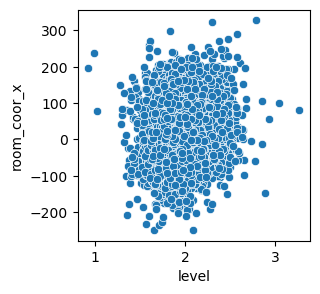

In [27]:
# plot a graph of room_coordinates against level:
plt.figure(figsize=(3, 3))
sns.scatterplot(data=df_combine, x='level', y='room_coor_x')

<AxesSubplot:xlabel='level', ylabel='room_coor_y'>

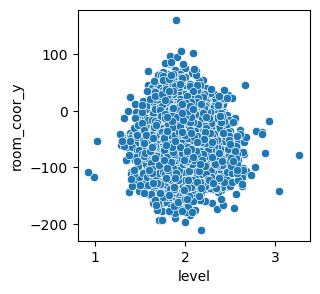

In [28]:
# plot a graph of room_coordinates against level:
plt.figure(figsize=(3, 3))
sns.scatterplot(data=df_combine, x='level', y='room_coor_y')

- Out of game levels 1-4, it is noticed that students tend to spend more time on more activitiest at Level 2 of the game.

## 4. Preprocessing

As there are 3 questions being answered by students, 3 models need to be run for correctness of 1-3 respectively.

In [29]:
# split data into train and test sets:
X_q1 = dataset_df
y_q1 = df_q1['correct_q1']
X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.2, random_state=42)

In [30]:
X_q2 = dataset_df
y_q2 = df_q2['correct_q2']
X_train_q2, X_test_q2, y_train_q2, y_test_q2 = train_test_split(X_q2, y_q2, test_size=0.2, random_state=42)

In [31]:
X_q3 = dataset_df
y_q3 = df_q3['correct_q3']
X_train_q3, X_test_q3, y_train_q3, y_test_q3 = train_test_split(X_q3, y_q3, test_size=0.2, random_state=42)

## 5. Modeling

#### Baseline Model - Predict half of the students will answer each of the question correctly.

In [32]:
0.5/(df_q1['correct_q1'].mean())

0.6872994574412229

In [33]:
0.5/(df_q2['correct_q2'].mean())

0.5108181936434982

In [34]:
0.5/(df_q3['correct_q3'].mean())

0.5353296678329622

- The basemodel accuracy for Qn1 is **68.7%**, for Qn2 is **51.1%** and for Qn3 is **53.5%**.

#### Training

Selection of models: **Gradient Boosting Decision Tree Model** and **Random Forest Model**

**a. Gradient Boosting Decision Tree Model** 

In [35]:
# instantiate the model:
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1)

In [36]:
# fit the model to training data:
gbc.fit(X_train_q1, y_train_q1)

GradientBoostingClassifier()

In [37]:
# predict on the training set
y_train_q1_pred = gbc.predict(X_train_q1)

# Evaluate the model's performance on the training set
train_q1_accuracy = accuracy_score(y_train_q1, y_train_q1_pred)
print("Training Accuracy for Qn1:", train_q1_accuracy)

# Predict on the testing set
y_test_q1_pred = gbc.predict(X_test_q1)

# Evaluate the model's performance on the testing set
test_q1_accuracy = accuracy_score(y_test_q1, y_test_q1_pred)
print("Testing Accuracy for Qn1:", test_q1_accuracy)


Training Accuracy for Qn1: 0.7359541620245106
Testing Accuracy for Qn1: 0.7315934648843624


In [38]:
# repeat the same steps for Qn2:

gbc.fit(X_train_q2, y_train_q2)

y_train_q2_pred = gbc.predict(X_train_q2)
train_q2_accuracy = accuracy_score(y_train_q2, y_train_q2_pred)
print("Training Accuracy for Qn2:", train_q2_accuracy)

y_test_q2_pred = gbc.predict(X_test_q2)
test_q2_accuracy = accuracy_score(y_test_q2, y_test_q2_pred)
print("Testing Accuracy for Qn2:", test_q2_accuracy)

Training Accuracy for Qn2: 0.982704652766725
Testing Accuracy for Qn2: 0.9758115849777212


In [39]:
# repeat the same steps for Qn3:

gbc.fit(X_train_q3, y_train_q3)

y_train_q3_pred = gbc.predict(X_train_q3)
train_q3_accuracy = accuracy_score(y_train_q3, y_train_q3_pred)
print("Training Accuracy for Qn3:", train_q3_accuracy)

y_test_q3_pred = gbc.predict(X_test_q3)
test_q3_accuracy = accuracy_score(y_test_q3, y_test_q3_pred)
print("Testing Accuracy for Qn3:", test_q3_accuracy)

Training Accuracy for Qn3: 0.9352750809061489
Testing Accuracy for Qn3: 0.9338001273074474


In [40]:
# understand the feature importance:
gbc.feature_importances_

array([0.00789635, 0.0140257 , 0.02024891, 0.02518936, 0.02089973,
       0.07096029, 0.10944895, 0.01034638, 0.03862161, 0.02905384,
       0.02144625, 0.02836727, 0.07686788, 0.08330486, 0.07727424,
       0.03015267, 0.0374186 , 0.04345084, 0.10984477, 0.0686085 ,
       0.07657298])

In [41]:
# create a dataframe including all features taken by the model, and the corresponding coefficients:
gbc_coef = pd.DataFrame(X_q1.columns, gbc.feature_importances_)

Text(0.5, 1.0, 'Gradient Boosting: Importance of Features')

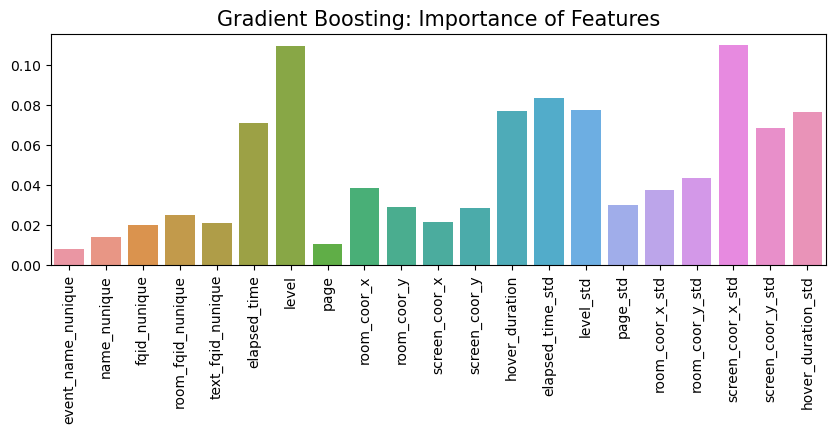

In [42]:
# plot a bar chart indicating the magnitude of each feature:
plt.figure(figsize=(10,3))
fig=sns.barplot(data=gbc_coef, x= X_q1.columns, y=gbc.feature_importances_)
fig.set_xticklabels(labels=X_q1.columns, rotation=90)
plt.title('Gradient Boosting: Importance of Features', fontsize=15)

**b. Random Forest Model**

In [43]:
# instantiate the model:
rfc = RandomForestClassifier()

In [44]:
# fit the model to the training data:
rfc.fit(X_train_q1, y_train_q1)

# predict on the training set
y_train_q1_pred = rfc.predict(X_train_q1)

# Evaluate the model's performance on the training set
train_q1_accuracy = accuracy_score(y_train_q1, y_train_q1_pred)
print("Training Accuracy for Qn1:", train_q1_accuracy)

# Predict on the testing set
y_test_q1_pred = rfc.predict(X_test_q1)

# Evaluate the model's performance on the testing set
test_q1_accuracy = accuracy_score(y_test_q1, y_test_q1_pred)
print("Testing Accuracy for Qn1:", test_q1_accuracy)

Training Accuracy for Qn1: 1.0
Testing Accuracy for Qn1: 0.7328665393592192


In [45]:
# repeat the same steps for Qn2:

rfc.fit(X_train_q2, y_train_q2)

y_train_q2_pred = rfc.predict(X_train_q2)
train_q2_accuracy = accuracy_score(y_train_q2, y_train_q2_pred)
print("Training Accuracy for Qn2:", train_q2_accuracy)

y_test_q2_pred = rfc.predict(X_test_q2)
test_q2_accuracy = accuracy_score(y_test_q2, y_test_q2_pred)
print("Testing Accuracy for Qn2:", test_q2_accuracy)

Training Accuracy for Qn2: 0.9998938935752559
Testing Accuracy for Qn2: 0.9789942711648632


In [46]:
# repeat the same steps for Qn3:

rfc.fit(X_train_q3, y_train_q3)

y_train_q3_pred = rfc.predict(X_train_q3)
train_q3_accuracy = accuracy_score(y_train_q3, y_train_q3_pred)
print("Training Accuracy for Qn3:", train_q3_accuracy)

y_test_q3_pred = rfc.predict(X_test_q3)
test_q3_accuracy = accuracy_score(y_test_q3, y_test_q3_pred)
print("Testing Accuracy for Qn3:", test_q3_accuracy)

Training Accuracy for Qn3: 0.999946946787628
Testing Accuracy for Qn3: 0.9338001273074474


In [47]:
# create a dataframe including all features taken by the model, and the corresponding coefficients:
rfc_coef = pd.DataFrame(X_q1.columns, rfc.feature_importances_)

Text(0.5, 1.0, 'Random Forest: Importance of Features')

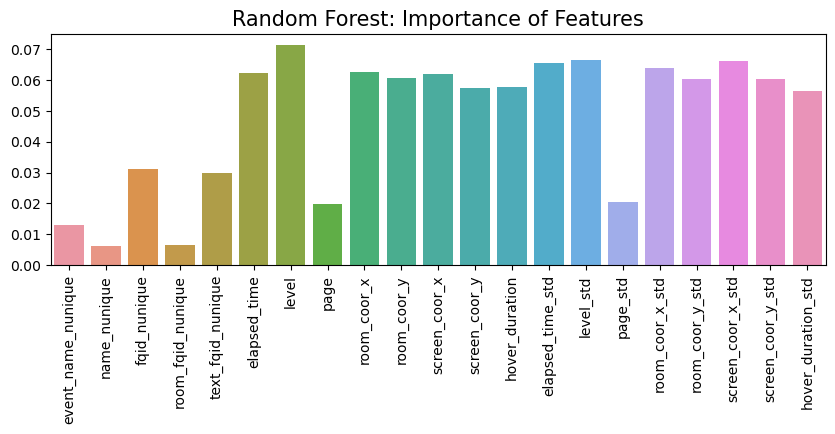

In [48]:
# plot a bar chart indicating the magnitude of each feature:
plt.figure(figsize=(10,3))
fig=sns.barplot(data=rfc_coef, x= X_q1.columns, y=rfc.feature_importances_)
fig.set_xticklabels(labels=X_q1.columns, rotation=90)
plt.title('Random Forest: Importance of Features', fontsize=15)

## 6. Evaluation

The performance of the models are summarised using a table:

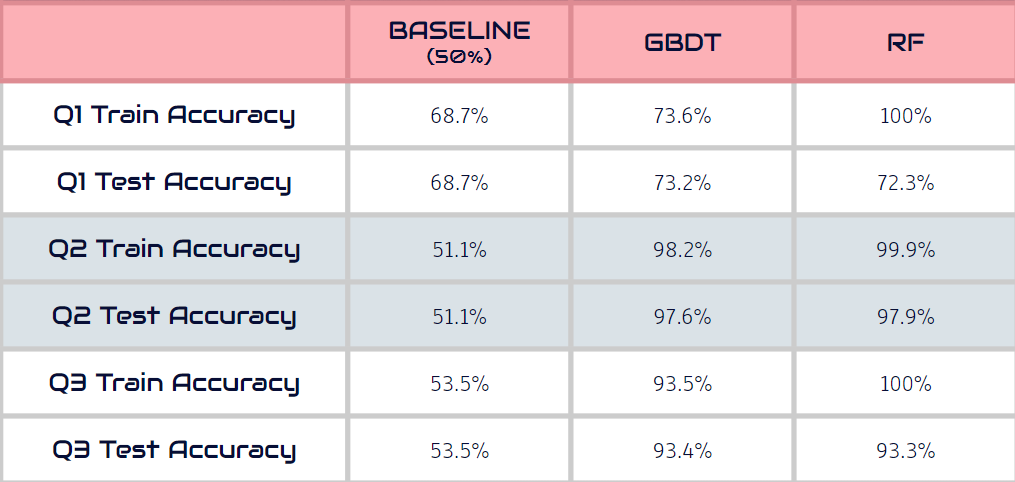

Text(0.5, 1.0, 'ROC AUC Comparison for Q1')

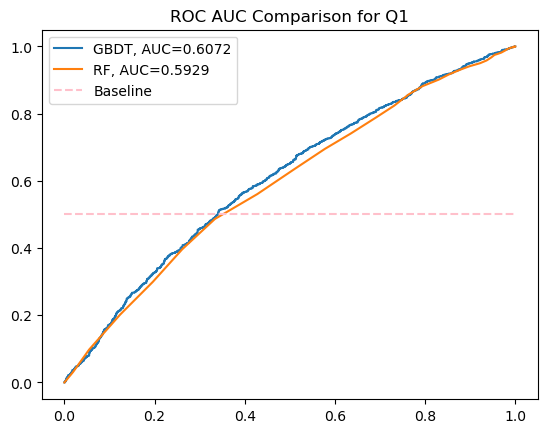

In [49]:
# plot a ROC AUC curve to compare GBDT and RF:
# set up plotting area
plt.figure(0).clf()

# GBDT
pred_gbc = gbc.predict_proba(X_test_q1)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_q1, pred_gbc)
auc = round(metrics.roc_auc_score(y_test_q1, pred_gbc), 4)
plt.plot(fpr,tpr,label="GBDT, AUC="+str(auc))

# RF:
pred_rfc = rfc.predict_proba(X_test_q1)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_q1, pred_rfc)
auc = round(metrics.roc_auc_score(y_test_q1, pred_rfc), 4)
plt.plot(fpr,tpr,label="RF, AUC="+str(auc))

baseline_fpr = np.linspace(0, 1, 100)
baseline_tpr = np.full_like(baseline_fpr, 0.5)
plt.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline', color='pink')

# add legend
plt.legend()
plt.title("ROC AUC Comparison for Q1")

Text(0.5, 1.0, 'ROC AUC Comparison for Q2')

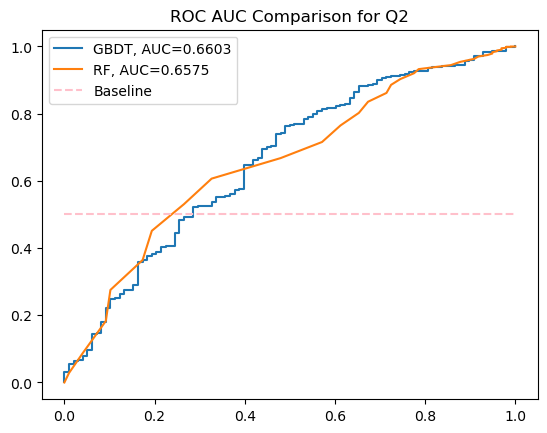

In [50]:
# repeat it for Qn2:
plt.figure(0).clf()

# GBDT
pred_gbc = gbc.predict_proba(X_test_q2)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_q2, pred_gbc)
auc = round(metrics.roc_auc_score(y_test_q2, pred_gbc), 4)
plt.plot(fpr,tpr,label="GBDT, AUC="+str(auc))

# RF:
pred_rfc = rfc.predict_proba(X_test_q2)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_q2, pred_rfc)
auc = round(metrics.roc_auc_score(y_test_q2, pred_rfc), 4)
plt.plot(fpr,tpr,label="RF, AUC="+str(auc))

baseline_fpr = np.linspace(0, 1, 100)
baseline_tpr = np.full_like(baseline_fpr, 0.5)
plt.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline', color='pink')

# add legend
plt.legend()
plt.title("ROC AUC Comparison for Q2")

Text(0.5, 1.0, 'ROC AUC Comparison for Q3')

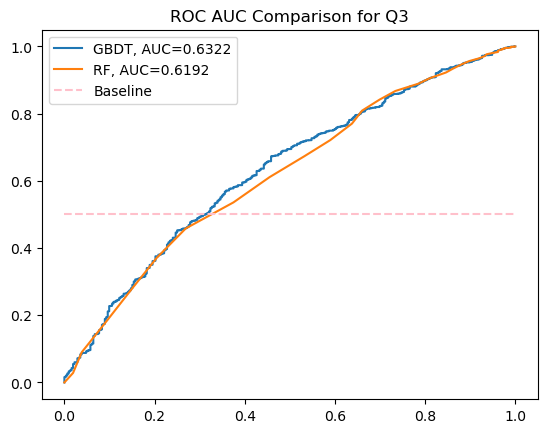

In [51]:
# repeat it for Qn3:
plt.figure(0).clf()

# GBDT
pred_gbc = gbc.predict_proba(X_test_q3)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_q3, pred_gbc)
auc = round(metrics.roc_auc_score(y_test_q3, pred_gbc), 4)
plt.plot(fpr,tpr,label="GBDT, AUC="+str(auc))

# RF:
pred_rfc = rfc.predict_proba(X_test_q3)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_q3, pred_rfc)
auc = round(metrics.roc_auc_score(y_test_q3, pred_rfc), 4)
plt.plot(fpr,tpr,label="RF, AUC="+str(auc))

baseline_fpr = np.linspace(0, 1, 100)
baseline_tpr = np.full_like(baseline_fpr, 0.5)
plt.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline', color='pink')

# add legend
plt.legend()
plt.title("ROC AUC Comparison for Q3")

- The results of **Random Forest Model** show a bad overfitting on the train set, and the ROC AUC curve underperforms that of **Gradient Boosting Decision Tree Model** for all 3 questions. I will choose to deploy **Gradient Boosting Decision Tree Model** for the actual predictions.

## 7. Conclusion

**GBDT and RF model performance：**
- Model accuracies are largely different across 3 questions. Qn 2 and 3 have better prediction outcomes as compared to Qn 1.
- RF tends to overfit on train set (although online resources say otherwise).
- GBDT outperforms RF as shown in ROC/AUC curve.

## 8. Further Work

**Possible ways to improve model performance:**
- Expand game log data to more levels and include more questions for students to answer at the end of the last level. More data points may increase the prediction accuracy. But it will likely introduce more variance to the dataset and the model could be more prone to overfitting.
- Test other tree models (e.g. CART Model) and adjust parameters of pruning.

**In answering to the Problem Statement:**
- A model of the best performance performance will be deployed. 
- Learning outcomes can be assessed using the game log data. If the failure rate of students is predicted higher than expected, we should look into ways to improve the game design in order to achieve optimal learning results. 
- Based on different predictions of students learning outcomes, a recommendation system can be built to feed weaker students with suitable game content for more practice. 